In [1]:
import pandas as pd
import seaborn as sns

sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize': (20, 10)})

In [2]:
data_sets = ["data/results/asap.csv", "data/results/throttled.csv"]
data_set_names = ["asap", "throttled"]

In [3]:
dfs = []
for p, n in zip(data_sets, data_set_names):
    df = pd.read_csv(p)
    df["simulation_id"] = n
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)

In [4]:
df.groupby("simulation_id").size()

simulation_id
asap         10999912
throttled    10999912
dtype: int64

In [5]:
auction_df = df[df["kind"].isin(["win", "no win"])]

In [6]:
win_df = df[df["kind"] == "win"]

In [7]:
requests_distribution = pd.read_csv("data/request_distribution.csv", index_col="window")

In [8]:
import math
import numpy as np
from matplotlib import pyplot as plt
import distributions
import seaborn as sns


def budget_consumption(df: pd.DataFrame, requests_distribution: np.ndarray):
    simulations = df["simulation_id"].unique().tolist()
    values_df = (df
                 .groupby(["window", "campaign_id", "simulation_id"])
                 .aggregate(value=("bid_value", np.sum))
                 .unstack(fill_value=0)
                 .unstack(fill_value=0))["value"]

    budget_spending_df = values_df.cumsum() / values_df.sum()
    ideal_budget_spending_df = distributions.normalize(requests_distribution).cumsum()

    rows = math.ceil((len(simulations) + 1) / 2)
    fig, axs = plt.subplots(rows, 2, sharey="row", figsize=(20, 10))

    ax = axs[0, 0]
    ax.set_title("ideal")
    sns.lineplot(data=ideal_budget_spending_df, ax=ax)

    for ax_ord, simulation_id in enumerate(simulations, 1):
        ax = axs[ax_ord // 2, ax_ord % 2]
        ax.set_title(simulation_id)
        sns.lineplot(data=budget_spending_df[simulation_id], ax=ax)

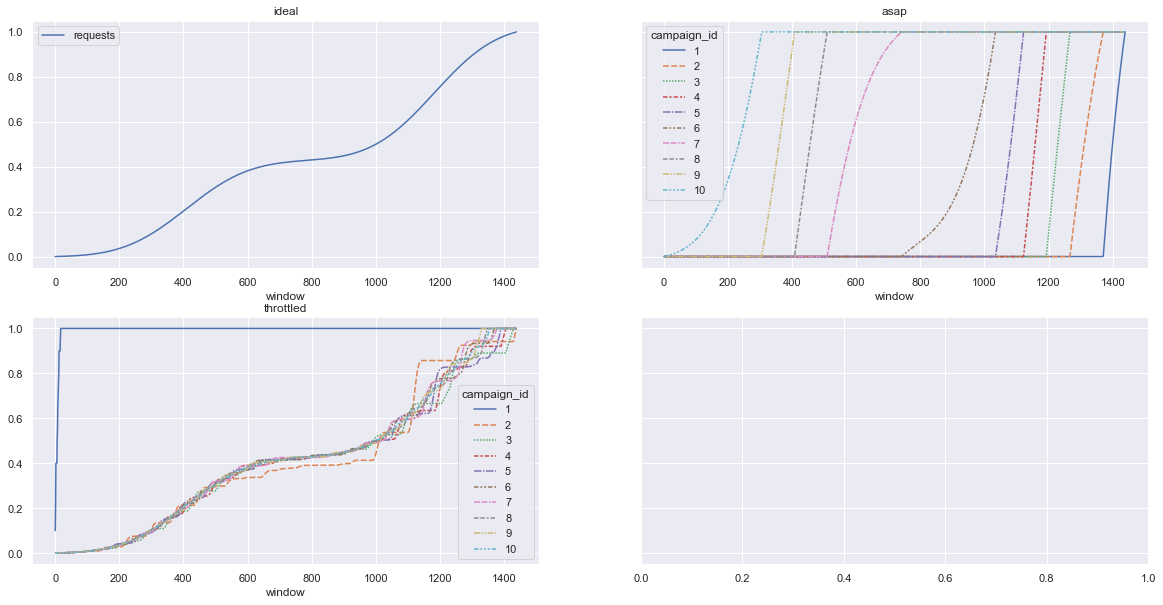

In [9]:
budget_consumption(win_df, requests_distribution)

In [10]:
def lifetime(df: pd.DataFrame):
    window_df = (df.groupby(["simulation_id", "campaign_id"])
                 .aggregate(window_width=("window", lambda w: np.max(w) - np.min(w)),
                            window_unique=("window", pd.Series.nunique)))
    window_df.reset_index(inplace=True)
    fig, axs = plt.subplots(2, 1, sharey="row")
    sns.boxplot(x="window_width", y="simulation_id", data=window_df, ax=axs[0])
    sns.boxplot(x="window_unique", y="simulation_id", data=window_df, ax=axs[1])

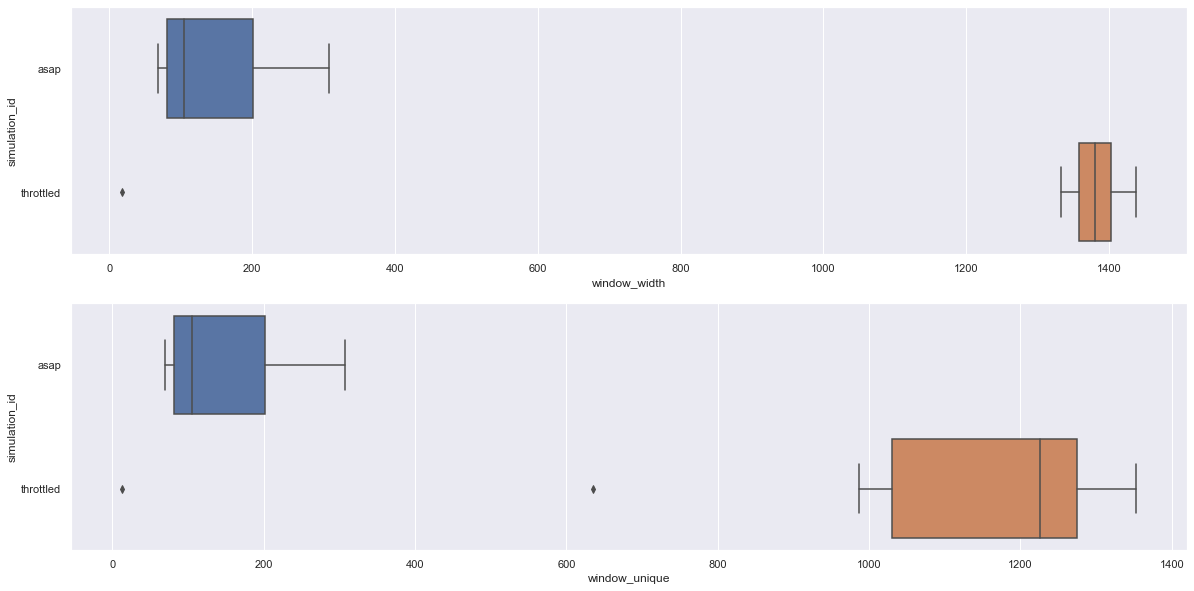

In [11]:
lifetime(win_df)

In [12]:
summary_fill_df = auction_df.groupby("simulation_id").aggregate(
    requests=("request", np.size),
    wins=("kind", lambda s: len(s[s == "win"])),
    value_sum=("bid_value", np.sum),
    value_min=("bid_value", lambda s: np.min(s[s > 0])),
    value_max=("bid_value", np.max),
)
summary_fill_df["fill_rate"] = summary_fill_df["wins"] / summary_fill_df["requests"]
summary_fill_df["avg_value"] = summary_fill_df["value_sum"] / summary_fill_df["wins"]
summary_fill_df

,requests,wins,value_sum,value_min,value_max,fill_rate,avg_value
simulation_id,,,,,,,
asap,999992,999992,14819245,11,19,1.00000,14.819364
throttled,999992,999902,13915559,11,20,0.99991,13.916923
